In [1]:
#Yankee Stadium MTA Exit Volume Model
#Matt Samelson

#Data from:  http://web.mta.info/developers/turnstile.html

#This dataset shows entry & exit counter values for each turnstile device in each station in the 
#NYC Subway System. 

# Modeling

#I developed a model for 4hr-interval exit count by station to predict MTA exit volume
#at Yankee Stadium.  

#The model utilizes a Random Forest Regressor.  Attempts to simplify to a linear model were
#unsuccessful due to a severe decline in performance (attempts to fit a linear model not shown here)


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import sklearn
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
import re
from datetime import date, timedelta
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
pd.set_option('display.float_format', lambda x: '%.2f' % x)
%matplotlib inline


In [3]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Data

## Data Munging

In [4]:
# This is a function to be used later to "prettify" the statmodels Augmented Dickey-Fuller Test for timeseries staionarity.
# For use with SARIMAX model belwo

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [5]:
#Generate urls for Turnstile data spanning the 2013 Yankee's season

#Create date portion of URL link for individual weekly file downloads on MTA website

def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

datelist = []  
    
for result in perdelta(date(2013, 3, 30), date(2013, 10, 12), timedelta(days=7)):
    datelist.append(str(date.strftime(result, "%y%m%d")))
  
print (datelist)

['130330', '130406', '130413', '130420', '130427', '130504', '130511', '130518', '130525', '130601', '130608', '130615', '130622', '130629', '130706', '130713', '130720', '130727', '130803', '130810', '130817', '130824', '130831', '130907', '130914', '130921', '130928', '131005']


In [6]:
#print number of files to download

print ("Number of Files: %d" %(len(datelist)))

Number of Files: 28


In [7]:
#Download Data

names = ['CA','UNIT','SCP', \
         'DATE1','TIME1','DESC1','ENTRIES1','EXITS1', \
         'DATE2','TIME2','DESC2','ENTRIES2','EXITS2', \
         'DATE3','TIME3','DESC3','ENTRIES3','EXITS3', \
         'DATE4','TIME4','DESC4','ENTRIES4','EXITS4', \
         'DATE5','TIME5','DESC5','ENTRIES5','EXITS5', \
         'DATE6','TIME6','DESC6','ENTRIES6','EXITS6', \
         'DATE7','TIME7','DESC7','ENTRIES7','EXITS7', \
         'DATE8','TIME8','DESC8','ENTRIES8','EXITS8']


season_2013_df = pd.DataFrame()

for i in range(0,len(datelist)):
    
    #print "Processing File %d \n" %(i+1)
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"+ \
          datelist[i] + \
          ".txt"
    temp_df = pd.read_csv(url,header=None,names=names)    
    season_2013_df = pd.concat([season_2013_df, temp_df])
    #print "Completed File %d \n" %(i+1)

print ("File Downloads Completed")



File Downloads Completed


In [8]:
season_2013_df.shape

(838444, 43)

In [9]:
#Reshape data into a format with a single column for each feature

season_2013_df = pd.lreshape(season_2013_df, \
                     {'DATE': ['DATE1', 'DATE2', 'DATE3','DATE4','DATE5','DATE6','DATE7','DATE8'],
                      'TIME': ['TIME1', 'TIME2', 'TIME3','TIME4','TIME5','TIME6','TIME7','TIME8'],
                      'DESC': ['DESC1', 'DESC2', 'DESC3','DESC4','DESC5','DESC6','DESC7','DESC8'],
                      'ENTRIES': ['ENTRIES1', 'ENTRIES2', 'ENTRIES3','ENTRIES4','ENTRIES5','ENTRIES6',\
                                 'ENTRIES7','ENTRIES8'],
                      'EXITS': ['EXITS1', 'EXITS2', 'EXITS3','EXITS4','EXITS5','EXITS6',\
                                'EXITS7','EXITS8']})                          

In [10]:
#Select only Yankee Stadium turnstile data at "Regular' audit intervals

season_2013_df = season_2013_df.loc[(season_2013_df['UNIT']=='R195') & (season_2013_df['DESC']=='REGULAR')]

#Convert entries and exits to numeric and date to datetime

season_2013_df['ENTRIES'] = pd.to_numeric(season_2013_df['ENTRIES'],errors='coerce')
season_2013_df['EXITS']  = pd.to_numeric(season_2013_df['EXITS'],errors='coerce')
season_2013_df['DATE'] = pd.to_datetime(season_2013_df['DATE'], errors='coerce')

#The date filter below trims all data that is outside the 2013 baseball season 

season_2013_df = season_2013_df[((season_2013_df['DATE'] > '2013-03-31') & (season_2013_df['DATE'] < '2013-10-01'))]

In [11]:
season_2013_df.shape

(40231, 8)

In [12]:
season_2013_df.head()

,CA,SCP,UNIT,DATE,TIME,DESC,ENTRIES,EXITS
40235,N203,00-00-00,R195,2013-04-02,20:22:00,REGULAR,3534078.00,3481106.00
40236,N203,00-00-00,R195,2013-04-04,04:22:00,REGULAR,3535935.00,3482762.00
40237,N203,00-00-00,R195,2013-04-05,12:22:00,REGULAR,3538331.00,3484602.00
40240,N203,00-00-01,R195,2013-04-01,00:22:00,REGULAR,5100494.00,2635205.00
40241,N203,00-00-01,R195,2013-04-02,00:22:00,REGULAR,5103076.00,2636494.00


In [13]:
season_2013_df['TIME'].unique()

array(['20:22:00', '04:22:00', '12:22:00', '00:22:00', '08:22:00',
       '16:22:00', '07:47:45', '14:47:11', '08:06:28', '07:48:55',
       '07:47:09', '07:59:39', '09:26:31', '00:08:20', '00:39:15',
       '00:49:29', '01:00:12', '01:10:54', '01:21:37', '01:32:20',
       '07:00:34', '07:54:37', '07:48:16', '07:19:39', '13:58:06',
       '08:39:22', '07:55:44', '07:01:48', '06:54:33', '13:54:25',
       '14:05:13', '14:15:55', '08:08:24', '07:28:36', '07:26:40',
       '07:22:46', '15:01:50', '13:51:06', '08:38:36', '00:09:41',
       '00:40:17', '00:50:49', '01:01:32', '01:12:14', '01:22:57',
       '08:09:41', '07:10:08', '07:20:59', '08:00:17', '13:55:50',
       '14:06:33', '14:17:16', '14:16:36', '07:28:16', '09:25:27',
       '09:52:19', '00:11:01', '00:41:27', '00:52:09', '01:02:52',
       '01:13:35', '01:24:17', '06:52:44', '07:26:53', '07:28:18',
       '07:18:09', '07:46:26', '06:58:40', '15:04:34', '13:57:11',
       '14:07:53', '14:18:36', '14:44:05', '08:10:23', '00:12:

In [14]:
#Data munging: make datetime object of dates, arrange data by station/turnstyle/date/time,
#make entries and exits into integers, trim data of erroneous observations (< 0 and >20000),
#drop na values

#Arrange 'odometer' reading by SCP in date time order

season_2013_df.sort_values(['UNIT','CA','SCP','DATE','TIME'],inplace=True)

#Calculate the 'true' traffic count from 'odometer, readings for each audit period by subtracting
#the reading from the prior period

season_2013_df['ENTRIES'] = season_2013_df['ENTRIES'].diff()
season_2013_df['EXITS'] = season_2013_df['EXITS'].diff()

#Remove outlying and negative true count values

season_2013_df = season_2013_df[(season_2013_df['ENTRIES'] < 20000) & (season_2013_df['ENTRIES'] >= 0)]
season_2013_df = season_2013_df[(season_2013_df['EXITS'] < 20000) & (season_2013_df['EXITS'] >= 0) ]
season_2013_df = season_2013_df.dropna()
 

In [15]:
season_2013_df.head(50)

,CA,SCP,UNIT,DATE,TIME,DESC,ENTRIES,EXITS
1702690,N203,00-00-00,R195,2013-04-01,04:22:00,REGULAR,13.00,12.00
2492566,N203,00-00-00,R195,2013-04-01,08:22:00,REGULAR,201.00,118.00
3268375,N203,00-00-00,R195,2013-04-01,12:22:00,REGULAR,223.00,534.00
878063,N203,00-00-00,R195,2013-04-01,16:22:00,REGULAR,424.00,500.00
1702691,N203,00-00-00,R195,2013-04-01,20:22:00,REGULAR,773.00,259.00
2492567,N203,00-00-00,R195,2013-04-02,00:22:00,REGULAR,68.00,109.00
3268376,N203,00-00-00,R195,2013-04-02,04:22:00,REGULAR,11.00,13.00
4030650,N203,00-00-00,R195,2013-04-02,08:22:00,REGULAR,229.00,88.00
4782260,N203,00-00-00,R195,2013-04-02,12:22:00,REGULAR,264.00,239.00
5522312,N203,00-00-00,R195,2013-04-02,16:22:00,REGULAR,218.00,274.00


In [16]:
# Make a datetime object with date and hours from date and hours columns, set it to the dataframe
#index.  Drop the original date and hour columns.

season_2013_df['DATE'] = season_2013_df['DATE'].apply(lambda x: x.strftime('%Y-%m-%d'))
season_2013_df['DATETIME'] = season_2013_df['DATE'] + " " + season_2013_df['TIME']
season_2013_df['DATETIME'] = pd.to_datetime(season_2013_df['DATETIME'], errors='coerce')
season_2013_df = season_2013_df.set_index('DATETIME')
season_2013_df.drop(['DATE','TIME'],axis=1,inplace=True)

In [17]:
season_2013_df.head()


,CA,SCP,UNIT,DESC,ENTRIES,EXITS
DATETIME,,,,,,
2013-04-01 04:22:00,N203,00-00-00,R195,REGULAR,13.00,12.00
2013-04-01 08:22:00,N203,00-00-00,R195,REGULAR,201.00,118.00
2013-04-01 12:22:00,N203,00-00-00,R195,REGULAR,223.00,534.00
2013-04-01 16:22:00,N203,00-00-00,R195,REGULAR,424.00,500.00
2013-04-01 20:22:00,N203,00-00-00,R195,REGULAR,773.00,259.00


In [18]:
season_2013_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40188 entries, 2013-04-01 04:22:00 to 2013-09-30 20:22:00
Data columns (total 6 columns):
CA         40188 non-null object
SCP        40188 non-null object
UNIT       40188 non-null object
DESC       40188 non-null object
ENTRIES    40188 non-null float64
EXITS      40188 non-null float64
dtypes: float64(2), object(4)
memory usage: 2.1+ MB


In [19]:
season_2013_df.shape

(40188, 6)

In [20]:
#Resample the values so we have station exits (sum of all turnstiles) in "clean" 4 hour bands

turnstile_exits = season_2013_df['EXITS']

turnstile_exits_resampled = turnstile_exits.resample('4H',closed='right').sum()

In [21]:
turnstile_exits_resampled.shape

(1097,)

In [22]:
#Special munging work to eliminate an erroneous observation

turnstile_exits_resampled = turnstile_exits_resampled[turnstile_exits_resampled <20000] 



In [23]:
turnstile_exits_resampled.shape

(1096,)

In [24]:
turnstile_exits_resampled

DATETIME
2013-04-01 04:00:00     317.00
2013-04-01 08:00:00    1209.00
2013-04-01 12:00:00    9059.00
2013-04-01 16:00:00    9191.00
2013-04-01 20:00:00    3356.00
2013-04-02 00:00:00    1459.00
2013-04-02 04:00:00     396.00
2013-04-02 08:00:00     920.00
2013-04-02 12:00:00    2767.00
2013-04-02 16:00:00    3069.00
2013-04-02 20:00:00    3835.00
2013-04-03 00:00:00    1689.00
2013-04-03 04:00:00     404.00
2013-04-03 08:00:00    1307.00
2013-04-03 12:00:00    2716.00
2013-04-03 16:00:00    3749.00
2013-04-03 20:00:00   14369.00
2013-04-04 00:00:00    1814.00
2013-04-04 04:00:00     347.00
2013-04-04 08:00:00    1714.00
2013-04-04 12:00:00    1377.00
2013-04-04 16:00:00    4549.00
2013-04-04 20:00:00   15022.00
2013-04-05 00:00:00    1930.00
2013-04-05 04:00:00     635.00
2013-04-05 08:00:00     940.00
2013-04-05 12:00:00    2702.00
2013-04-05 16:00:00    3156.00
2013-04-05 20:00:00    4058.00
2013-04-06 00:00:00    1952.00
                        ...   
2013-09-26 00:00:00    1771.00

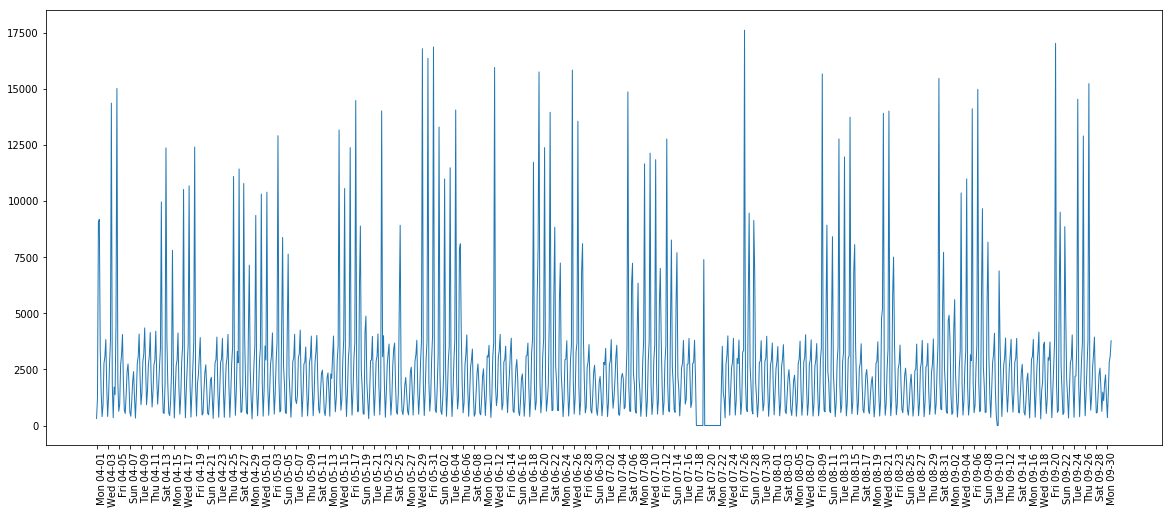

In [25]:
#Plot data

xticks = pd.date_range(start = turnstile_exits_resampled.index.min(), \
                       end =  turnstile_exits_resampled.index.max(), \
                       freq='2D')

plt.figure(figsize=(20,8))
plt.xticks(xticks,xticks.strftime("%a %m-%d"),rotation=90, ha="left")
plt.plot(turnstile_exits_resampled, linewidth=1)

In [26]:
#Examine a small irregular period of the data

turnstile_exits_resampled['20130715':'20130722']

DATETIME
2013-07-15 00:00:00   1602.00
2013-07-15 04:00:00    428.00
2013-07-15 08:00:00   1288.00
2013-07-15 12:00:00   2574.00
2013-07-15 16:00:00   2775.00
2013-07-15 20:00:00   3796.00
2013-07-16 00:00:00   2192.00
2013-07-16 04:00:00    955.00
2013-07-16 08:00:00   1178.00
2013-07-16 12:00:00   2722.00
2013-07-16 16:00:00   2742.00
2013-07-16 20:00:00   3882.00
2013-07-17 00:00:00   2259.00
2013-07-17 04:00:00    800.00
2013-07-17 08:00:00   1019.00
2013-07-17 12:00:00   2777.00
2013-07-17 16:00:00   2799.00
2013-07-17 20:00:00   3799.00
2013-07-18 00:00:00   2164.00
2013-07-18 04:00:00      0.00
2013-07-18 08:00:00      0.00
2013-07-18 12:00:00      0.00
2013-07-18 16:00:00      0.00
2013-07-18 20:00:00      0.00
2013-07-19 00:00:00      0.00
2013-07-19 04:00:00      0.00
2013-07-19 08:00:00      0.00
2013-07-19 12:00:00   7397.00
2013-07-19 16:00:00      0.00
2013-07-19 20:00:00      0.00
2013-07-20 00:00:00      0.00
2013-07-20 04:00:00      0.00
2013-07-20 08:00:00      0.00
2

In [27]:
#It turns out that the "irregular" period on the figure accurately represents the data in the
#original data provided.  In most cases (except the one observation removed above), it is not
#possible to conclude whether the data is erroneous and should be removed or accurate.  Accordingly
#this data is left in.

In [28]:
season_2013_df = season_2013_df.resample('4H',closed='right').sum()

In [29]:
season_2013_df.head()

,ENTRIES,EXITS
DATETIME,,
2013-04-01 04:00:00,308.00,317.00
2013-04-01 08:00:00,4031.00,1209.00
2013-04-01 12:00:00,5702.00,9059.00
2013-04-01 16:00:00,10895.00,9191.00
2013-04-01 20:00:00,17855.00,3356.00


In [30]:
#Add categorical indicators to dataframe showing 1) if a home game took place and 2) the opposing team

#Import Yankee Home Game Indicator

home_games_df = pd.read_csv('YankeesHomeGames2013.csv')
home_games_df['Date'] = pd.to_datetime(home_games_df['Date'], errors='coerce')
home_games_df['Date'] = home_games_df['Date'].map(lambda x: x.strftime('%m-%d-%Y'))
home_games_dict = dict(zip(list(home_games_df['Date']), list(home_games_df['Opponent'])))

In [31]:
home_games_dict

{'04-01-2013': 'BOS',
 '04-03-2013': 'BOS',
 '04-04-2013': 'BOS',
 '04-12-2013': 'BAL',
 '04-13-2013': 'BAL',
 '04-14-2013': 'BAL',
 '04-16-2013': 'ARI',
 '04-17-2013': 'ARI',
 '04-18-2013': 'ARI',
 '04-25-2013': 'TOR',
 '04-26-2013': 'TOR',
 '04-27-2013': 'TOR',
 '04-28-2013': 'TOR',
 '04-29-2013': 'HOU',
 '04-30-2013': 'HOU',
 '05-01-2013': 'HOU',
 '05-03-2013': 'OAK',
 '05-04-2013': 'OAK',
 '05-05-2013': 'OAK',
 '05-14-2013': 'SEA',
 '05-15-2013': 'SEA',
 '05-16-2013': 'SEA',
 '05-17-2013': 'TOR',
 '05-18-2013': 'TOR',
 '05-29-2013': 'NYM',
 '05-30-2013': 'NYM',
 '05-31-2013': 'BOS',
 '06-01-2013': 'BOS',
 '06-02-2013': 'BOS',
 '06-03-2013': 'CLE',
 '06-04-2013': 'CLE',
 '06-05-2013': 'CLE',
 '06-19-2013': 'LAD',
 '06-20-2013': 'TBR',
 '06-21-2013': 'TBR',
 '06-22-2013': 'TBR',
 '06-23-2013': 'TBR',
 '06-25-2013': 'TEX',
 '06-26-2013': 'TEX',
 '06-27-2013': 'TEX',
 '07-05-2013': 'BAL',
 '07-06-2013': 'BAL',
 '07-07-2013': 'BAL',
 '07-08-2013': 'KCR',
 '07-09-2013': 'KCR',
 '07-10-20

In [32]:
#Create the factor variable columns for home game indicator and team

season_2013_df['HOMEGAME'] = 0
season_2013_df['TEAM'] = 'NoGame'

In [33]:
#Iterate through the HOMEGAME and TEAM colunms and set value to '1' for times 12, 16, and 20 hour
#observations (you would likely not have fans showing up at 0, 4, or 8 hours) in the HOMEGAME
#column.  Set the TEAM column for those time observations to the opposing team

pd.options.mode.chained_assignment = None  # default='warn'

for date in range(0,len(season_2013_df.index)-1):
    if home_games_dict.get((season_2013_df.index[date].strftime('%m-%d-%Y')),'None') != 'None':
        if ((season_2013_df.index[date].hour == 12) | (season_2013_df.index[date].hour == 16) | \
            (season_2013_df.index[date].hour == 20) ):
                season_2013_df['HOMEGAME'][date] = 1
                season_2013_df['TEAM'][date] = home_games_dict[season_2013_df.index[date].strftime('%m-%d-%Y')]


In [34]:
season_2013_df.head()

,ENTRIES,EXITS,HOMEGAME,TEAM
DATETIME,,,,
2013-04-01 04:00:00,308.00,317.00,0,NoGame
2013-04-01 08:00:00,4031.00,1209.00,0,NoGame
2013-04-01 12:00:00,5702.00,9059.00,1,BOS
2013-04-01 16:00:00,10895.00,9191.00,1,BOS
2013-04-01 20:00:00,17855.00,3356.00,1,BOS


In [35]:
#Use Pandas label encoder function to change team strings to integer values.  This will allow
#for processing in sklearn.ensemble Random Forest Regressor

teams = season_2013_df['TEAM'].unique()
le = preprocessing.LabelEncoder()
le.fit(teams)
print (pd.DataFrame({'Teams':le.classes_}))
season_2013_df['TEAM'] = le.transform(season_2013_df['TEAM']) 


     Teams
0      ARI
1      BAL
2      BOS
3      CHW
4      CLE
5      DET
6      HOU
7      KCR
8      LAA
9      LAD
10     MIN
11     NYM
12  NoGame
13     OAK
14     SEA
15     SFG
16     TBR
17     TEX
18     TOR


In [36]:
season_2013_df.shape

(1097, 4)

In [37]:
season_2013_df.head()

,ENTRIES,EXITS,HOMEGAME,TEAM
DATETIME,,,,
2013-04-01 04:00:00,308.00,317.00,0,12
2013-04-01 08:00:00,4031.00,1209.00,0,12
2013-04-01 12:00:00,5702.00,9059.00,1,2
2013-04-01 16:00:00,10895.00,9191.00,1,2
2013-04-01 20:00:00,17855.00,3356.00,1,2


In [38]:
season_2013_df['DAYOFWEEK'] = season_2013_df.index.dayofweek 
season_2013_df['HOUR'] = season_2013_df.index.hour 

In [39]:
season_2013_df.head()

,ENTRIES,EXITS,HOMEGAME,TEAM,DAYOFWEEK,HOUR
DATETIME,,,,,,
2013-04-01 04:00:00,308.00,317.00,0,12,0,4
2013-04-01 08:00:00,4031.00,1209.00,0,12,0,8
2013-04-01 12:00:00,5702.00,9059.00,1,2,0,12
2013-04-01 16:00:00,10895.00,9191.00,1,2,0,16
2013-04-01 20:00:00,17855.00,3356.00,1,2,0,20


In [40]:
#Visual review of data suggests that values in excess of 20,000 are likely errors.  We replace the erroneous value with the 
#mean value of the series.


for i in range(len(season_2013_df.index)):
    
    if season_2013_df.iloc[i,1] > 20000:
        
        season_2013_df.iloc[i,1] = season_2013_df.iloc[:,1].mean()
        

In [41]:
season_2013_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1097 entries, 2013-04-01 04:00:00 to 2013-09-30 20:00:00
Freq: 4H
Data columns (total 6 columns):
ENTRIES      1097 non-null float64
EXITS        1097 non-null float64
HOMEGAME     1097 non-null int64
TEAM         1097 non-null int32
DAYOFWEEK    1097 non-null int64
HOUR         1097 non-null int64
dtypes: float64(2), int32(1), int64(3)
memory usage: 95.7 KB


In [42]:
#Determine 'split coordinates' for training and validation set creation
 
#Training set will comprise values from 4/1 - 8/31  
#Validation set will comprise values from 9/1 - 9/30

#The split point in the series is the index value where the label is midnight on 9/1/2013
#This is the first value in the Validation set

first_y = season_2013_df.index.get_loc('2013-09-01 00:00:00')
print(first_y)

917


In [43]:
#Length of the entire series

len(season_2013_df.index)

1097

### One-Hot-Encode

In [44]:
#One Hot Encode TEAM, DAYOFWEEK, HOUR

TEAM_ohe = OneHotEncoder()
DAYOFWEEK_ohe = OneHotEncoder()
HOUR_ohe = OneHotEncoder()
TEAM_ohe_array = TEAM_ohe.fit_transform(season_2013_df.TEAM.values.reshape(-1,1)).toarray()
DAYOFWEEK_ohe_array = DAYOFWEEK_ohe.fit_transform(season_2013_df.DAYOFWEEK.values.reshape(-1,1)).toarray()
HOUR_ohe_array = HOUR_ohe.fit_transform(season_2013_df.HOUR.values.reshape(-1,1)).toarray()

print(TEAM_ohe_array.shape, DAYOFWEEK_ohe_array.shape, HOUR_ohe_array.shape )


(1097, 19) (1097, 7) (1097, 6)


In [45]:
TEAM_ohe_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
DAYOFWEEK_ohe_array

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [47]:
HOUR_ohe_array

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [48]:
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
hours = [0,4,8,12,16,20]

season_2013_enc_df = season_2013_df.copy()

#TEAM_df = pd.DataFrame(TEAM_ohe_array, columns = ["TEAM_" + le.classes_[i]  for i in range(len(le.classes_))], index=season_2013_df.index)
#TEAM_df = TEAM_df.astype(int)
#season_2013_enc_df = pd.concat([season_2013_enc_df, TEAM_df], axis=1)

DAYOFWEEK_df = pd.DataFrame(DAYOFWEEK_ohe_array, columns = ["DAYOFWEEK_" + weekday for weekday in weekdays], index=season_2013_df.index)
DAYOFWEEK_df = DAYOFWEEK_df.astype(int)
season_2013_enc_df = pd.concat([season_2013_enc_df, DAYOFWEEK_df], axis=1)

HOUR_df = pd.DataFrame(HOUR_ohe_array, columns = ["HOUR_" + str(hour) for hour in hours], index=season_2013_df.index)
HOUR_df = HOUR_df.astype(int)
season_2013_enc_df = pd.concat([season_2013_enc_df, HOUR_df], axis=1)

season_2013_enc_df = season_2013_enc_df.drop(['DAYOFWEEK','TEAM','HOUR','ENTRIES'],axis=1)
#season_2013_enc_df = season_2013_enc_df.drop(['DAYOFWEEK','HOUR','ENTRIES'],axis=1)


season_2013_enc_df.shape

(1097, 15)

In [49]:
season_2013_enc_df.head()

,EXITS,HOMEGAME,DAYOFWEEK_Monday,DAYOFWEEK_Tuesday,DAYOFWEEK_Wednesday,DAYOFWEEK_Thursday,DAYOFWEEK_Friday,DAYOFWEEK_Saturday,DAYOFWEEK_Sunday,HOUR_0,HOUR_4,HOUR_8,HOUR_12,HOUR_16,HOUR_20
DATETIME,,,,,,,,,,,,,,,
2013-04-01 04:00:00,317.00,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2013-04-01 08:00:00,1209.00,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2013-04-01 12:00:00,9059.00,1,1,0,0,0,0,0,0,0,0,0,1,0,0
2013-04-01 16:00:00,9191.00,1,1,0,0,0,0,0,0,0,0,0,0,1,0
2013-04-01 20:00:00,3356.00,1,1,0,0,0,0,0,0,0,0,0,0,0,1


In [50]:
season_2013_enc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1097 entries, 2013-04-01 04:00:00 to 2013-09-30 20:00:00
Freq: 4H
Data columns (total 15 columns):
EXITS                  1097 non-null float64
HOMEGAME               1097 non-null int64
DAYOFWEEK_Monday       1097 non-null int32
DAYOFWEEK_Tuesday      1097 non-null int32
DAYOFWEEK_Wednesday    1097 non-null int32
DAYOFWEEK_Thursday     1097 non-null int32
DAYOFWEEK_Friday       1097 non-null int32
DAYOFWEEK_Saturday     1097 non-null int32
DAYOFWEEK_Sunday       1097 non-null int32
HOUR_0                 1097 non-null int32
HOUR_4                 1097 non-null int32
HOUR_8                 1097 non-null int32
HOUR_12                1097 non-null int32
HOUR_16                1097 non-null int32
HOUR_20                1097 non-null int32
dtypes: float64(1), int32(13), int64(1)
memory usage: 121.4 KB


### Train / Test Split

In [51]:
train_df = season_2013_enc_df[:917]
test_df = season_2013_enc_df[917:]

In [52]:
train_df.shape

(917, 15)

In [53]:
test_df.shape

(180, 15)

# SARIMAX

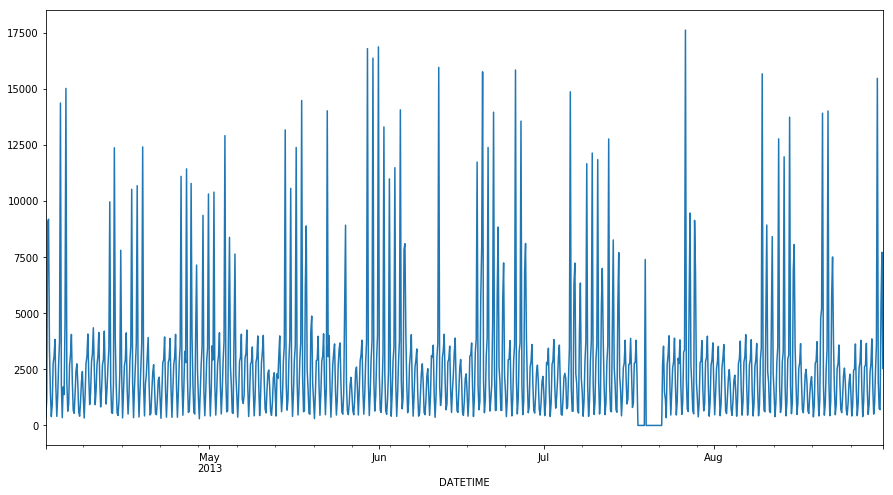

In [54]:
train_df['EXITS'].plot(figsize=(15,8))

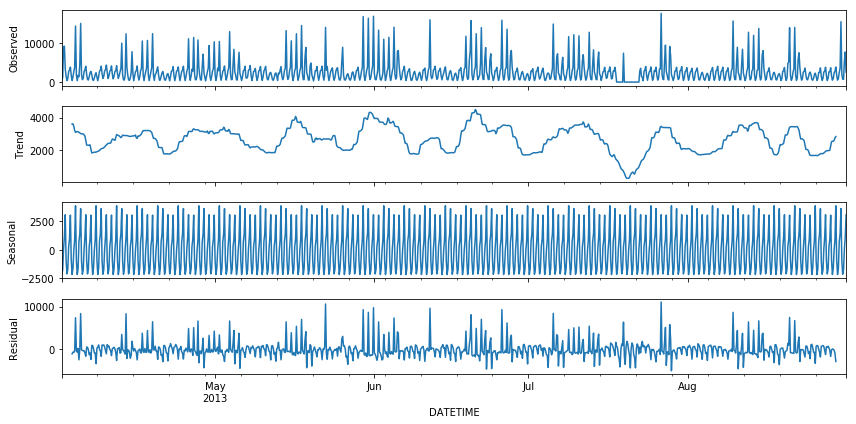

In [55]:
#The plot function below, used, alone, will not allow a figsize keyword.  The workaround is to temporarily change the
#the default matplotlib plot size defaults before rendering the decompose plots


with mpl.rc_context():
    mpl.rc("figure", figsize=(12,6))
    result = seasonal_decompose(train_df['EXITS'],model='add')
    result.plot();

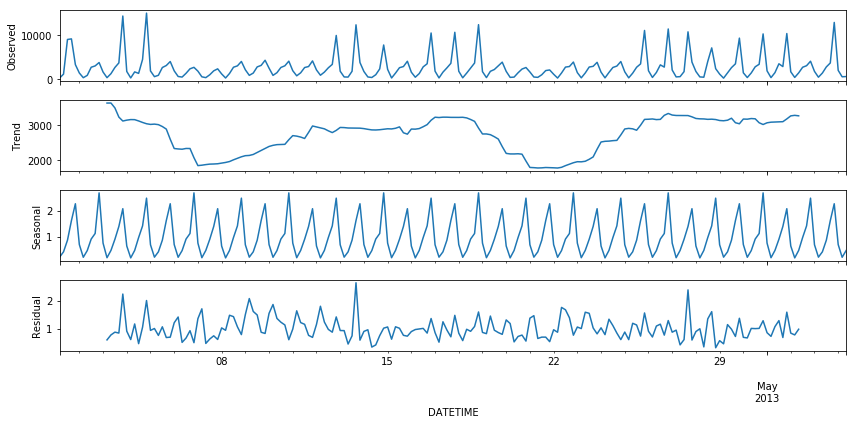

In [56]:
#Zooming in on the first 200 points

with mpl.rc_context():
    mpl.rc("figure", figsize=(12,6))
    result = seasonal_decompose(train_df['EXITS'][0:200],model='multiplicative')
    result.plot();

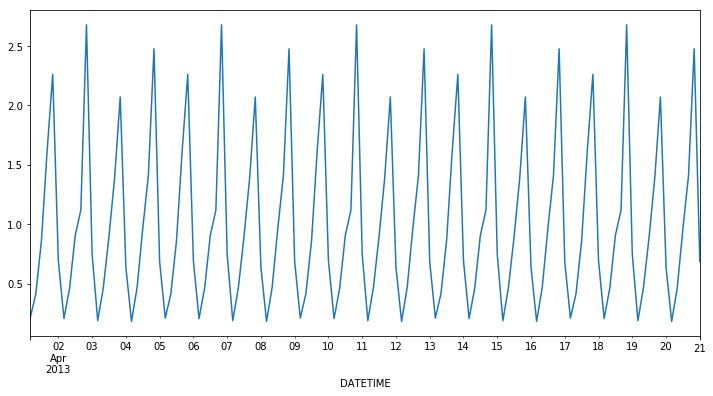

In [57]:
result.seasonal[0:120].plot(figsize=(12,6))

In [58]:
adf_test(season_2013_df['EXITS'])

#Per report below, time series becomes stationary with 21 lags

Augmented Dickey-Fuller Test: 
ADF test statistic       -6.57
p-value                   0.00
# lags used              18.00
# observations         1078.00
critical value (1%)      -3.44
critical value (5%)      -2.86
critical value (10%)     -2.57
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [59]:
# For SARIMA Orders we set seasonal=True and pass in an m value
#auto_arima(season_2013_df['EXITS'],seasonal=True,m=24,trace=True).summary()

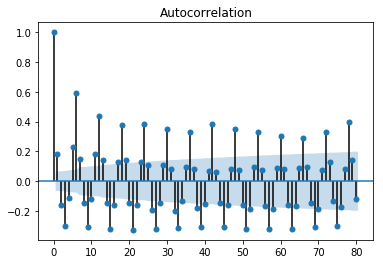

In [60]:
plot_acf(train_df['EXITS'],lags=80);

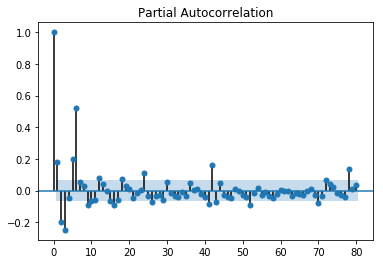

In [61]:
plot_pacf(train_df['EXITS'],lags=80);

In [62]:
season_2013_enc_df.head(6)

,EXITS,HOMEGAME,DAYOFWEEK_Monday,DAYOFWEEK_Tuesday,DAYOFWEEK_Wednesday,DAYOFWEEK_Thursday,DAYOFWEEK_Friday,DAYOFWEEK_Saturday,DAYOFWEEK_Sunday,HOUR_0,HOUR_4,HOUR_8,HOUR_12,HOUR_16,HOUR_20
DATETIME,,,,,,,,,,,,,,,
2013-04-01 04:00:00,317.00,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2013-04-01 08:00:00,1209.00,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2013-04-01 12:00:00,9059.00,1,1,0,0,0,0,0,0,0,0,0,1,0,0
2013-04-01 16:00:00,9191.00,1,1,0,0,0,0,0,0,0,0,0,0,1,0
2013-04-01 20:00:00,3356.00,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2013-04-02 00:00:00,1459.00,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [63]:
exog = season_2013_enc_df.columns[1:]

In [64]:
auto_arima(train_df['EXITS'],seasonal=True,m=24,trace=True,n_jobs=-1,stepwise=True,start_p=0,start_q=0,
           start_P=0,start_Q=0,exogenous=train_df[exog]).summary()
    
#auto_arima(train_df['EXITS'],seasonal=True,m=24,trace=True,n_jobs=-1,stepwise=True,start_p=0,start_q=0,
#           start_P=0,start_Q=0).summary()


Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 24); AIC=16475.670, BIC=16552.808, Fit time=0.225 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 24); AIC=16470.947, BIC=16557.727, Fit time=3.383 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 24); AIC=16465.736, BIC=16552.516, Fit time=3.891 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 24); AIC=16473.731, BIC=16546.048, Fit time=1.119 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 24); AIC=16463.861, BIC=16545.820, Fit time=0.333 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 0, 24); AIC=16465.736, BIC=16552.516, Fit time=3.126 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 24); AIC=16467.736, BIC=16559.337, Fit time=8.589 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 24); AIC=16448.254, BIC=16535.034, Fit time=0.616 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 0, 24); AIC=16450.073, BIC=16541.674, Fit time=7.166 seconds
Fit ARIMA:

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  917
Model:               SARIMAX(5, 0, 3)   Log Likelihood               -8176.361
Date:                Thu, 20 Feb 2020   AIC                          16400.721
Time:                        14:30:24   BIC                          16516.428
Sample:                    04-01-2013   HQIC                         16444.882
                         - 08-31-2013                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept              -1.8855     17.632     -0.107      0.915     -36.443      32.672
HOMEGAME             3250.0079    163.055     19.932      0.000    2930.426    3569.590
DAYOFWEEK_Monday      931.4987    148.520      6.272      0.000     640.405    1222.593
DAYOFWEEK_Tuesday    1292.1441    104.427     12.374      0.000    1087.471    1496.818
DAYOFWEEK_Wednesday  1291.2234    100.831     12.806      0.000    1093.598    1488.849
DAYOFWEEK_Thursday    956.0986    107.579      8.887      0.000     745.248    1166.949
DAYOFWEEK_Friday     1153.6017    102.997     11.200      0.000     951.731    1355.472
DAYOFWEEK_Saturday    567.8721    108.101      5.253      0.000     355.997     779.747
DAYOFWEEK_Sunday      245.7124    129.267      1.901      0.057      -7.645     499.070
HOUR_0                811.2107    464.518      1.746      0.081     -99.228    1721.649
HOUR_4               -402.1983    390.072     -1.031      0.302   -1166.725     362.328
HOUR_8                 72.1406    673.542      0.107      0.915   -1247.978    1392.259
HOUR_12               678.4448    260.501      2.604      0.009     167.872    1189.017
HOUR_16              1509.2803    311.657      4.843      0.000     898.444    2120.117
HOUR_20              3769.2727    194.355     19.394      0.000    3388.345    4150.200
ar.L1                   1.1818      0.217      5.438      0.000       0.756       1.608
ar.L2                  -0.7368      0.325     -2.268      0.023      -1.373      -0.100
ar.L3                   0.4205      0.172      2.445      0.015       0.083       0.758
ar.L4                  -0.1913      0.116     -1.656      0.098      -0.418       0.035
ar.L5                   0.2339      0.058      4.020      0.000       0.120       0.348
ma.L1                  -1.3276      0.218     -6.092      0.000      -1.755      -0.900
ma.L2                   0.7071      0.351      2.014      0.044       0.019       1.395
ma.L3                  -0.2664      0.182     -1.464      0.143      -0.623       0.090
sigma2               3.349e+06   1.13e+05     29.575      0.000    3.13e+06    3.57e+06
===================================================================================
Ljung-Box (Q):                       39.34   Jarque-Bera (JB):              1769.36
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             1.26
Prob(H) (two-sided):                  0.05   Kurtosis:                         9.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.86e+21. Standard errors may be unstable.
"""

In [65]:
train_df[exog].shape

(917, 14)

In [66]:
model = SARIMAX(train_df['EXITS'],exog=train_df[exog],order=(5,0,3),seasonal_order=(0,0,0,24),
                trend = 'ct', enforce_invertibility=False)

#model = SARIMAX(train_df['EXITS'],order=(3,0,2),seasonal_order=(2,0,1,24),
#                trend = 'ct', enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  EXITS   No. Observations:                  917
Model:               SARIMAX(5, 0, 3)   Log Likelihood               -8184.589
Date:                Thu, 20 Feb 2020   AIC                          16419.179
Time:                        14:30:28   BIC                          16539.706
Sample:                    04-01-2013   HQIC                         16465.180
                         - 08-31-2013                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept             139.8889    694.174      0.202      0.840   -1220.668    1500.446
drift                  -0.3302      3.438     -0.096      0.923      -7.069       6.408
HOMEGAME             3249.9815    149.963     21.672      0.000    2956.060    3543.903
DAYOFWEEK_Monday      931.5349    252.652      3.687      0.000     436.346    1426.724
DAYOFWEEK_Tuesday    1292.1604    219.165      5.896      0.000     862.605    1721.716
DAYOFWEEK_Wednesday  1291.2082    204.034      6.328      0.000     891.310    1691.107
DAYOFWEEK_Thursday    956.0938    212.717      4.495      0.000     539.176    1373.011
DAYOFWEEK_Friday     1153.6017    219.005      5.267      0.000     724.361    1582.843
DAYOFWEEK_Saturday    567.8230    200.846      2.827      0.005     174.172     961.474
DAYOFWEEK_Sunday      245.7253    262.266      0.937      0.349    -268.306     759.757
HOUR_0                811.2108    486.802      1.666      0.096    -142.903    1765.325
HOUR_4               -402.1993    436.049     -0.922      0.356   -1256.840     452.441
HOUR_8                 72.1405    625.143      0.115      0.908   -1153.118    1297.399
HOUR_12               678.4429    342.425      1.981      0.048       7.302    1349.584
HOUR_16              1509.2793    394.926      3.822      0.000     735.239    2283.319
HOUR_20              3769.2730    270.259     13.947      0.000    3239.575    4298.971
ar.L1                   0.0959     10.071      0.010      0.992     -19.644      19.836
ar.L2                  -0.7339      0.687     -1.068      0.285      -2.081       0.613
ar.L3                  -0.0340      7.296     -0.005      0.996     -14.334      14.266
ar.L4                  -0.2469      0.668     -0.370      0.712      -1.556       1.062
ar.L5                   0.0078      2.514      0.003      0.998      -4.919       4.935
ma.L1                  -0.2239     10.068     -0.022      0.982     -19.957      19.510
ma.L2                   0.5560      1.964      0.283      0.777      -3.293       4.405
ma.L3                  -0.0302      5.456     -0.006      0.996     -10.724      10.664
sigma2               3.342e+06   1.09e+05     30.679      0.000    3.13e+06    3.56e+06
===================================================================================
Ljung-Box (Q):                       58.67   Jarque-Bera (JB):              1737.46
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                             1.21
Prob(H) (two-sided):                  0.02   Kurtosis:                         9.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.91e+20. Standard errors may be unstable.
"""

In [67]:
# Obtain predicted values
start=len(train_df.index)
end=len(train_df.index)+len(test_df.index)-1
exog_forecast = test_df[exog]
predictions = results.predict(start=start, end=end, exog=exog_forecast,dynamic=False).rename('SARIMAX(5,0,3)(0,0,0,24) Predictions')
#predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMAX(3,0,2)(2,0,1,24) Predictions')

In [68]:
predictions

2013-09-01 00:00:00   1349.21
2013-09-01 04:00:00    263.68
2013-09-01 08:00:00   -282.27
2013-09-01 12:00:00   4899.57
2013-09-01 16:00:00   5225.17
2013-09-01 20:00:00   6508.06
2013-09-02 00:00:00   1470.48
2013-09-02 04:00:00    702.31
2013-09-02 08:00:00   1031.52
2013-09-02 12:00:00   4767.64
2013-09-02 16:00:00   5550.78
2013-09-02 20:00:00   7792.83
2013-09-03 00:00:00   2021.73
2013-09-03 04:00:00    858.64
2013-09-03 08:00:00   1292.91
2013-09-03 12:00:00   5109.56
2013-09-03 16:00:00   5944.98
2013-09-03 20:00:00   8223.70
2013-09-04 00:00:00   2024.44
2013-09-04 04:00:00    807.20
2013-09-04 08:00:00   1271.63
2013-09-04 12:00:00   5124.52
2013-09-04 16:00:00   5959.85
2013-09-04 20:00:00   8223.79
2013-09-05 00:00:00   1679.92
2013-09-05 04:00:00    463.82
2013-09-05 08:00:00    936.83
2013-09-05 12:00:00   4793.71
2013-09-05 16:00:00   5625.55
2013-09-05 20:00:00   7885.57
                        ...  
2013-09-26 00:00:00   1655.93
2013-09-26 04:00:00    442.35
2013-09-26

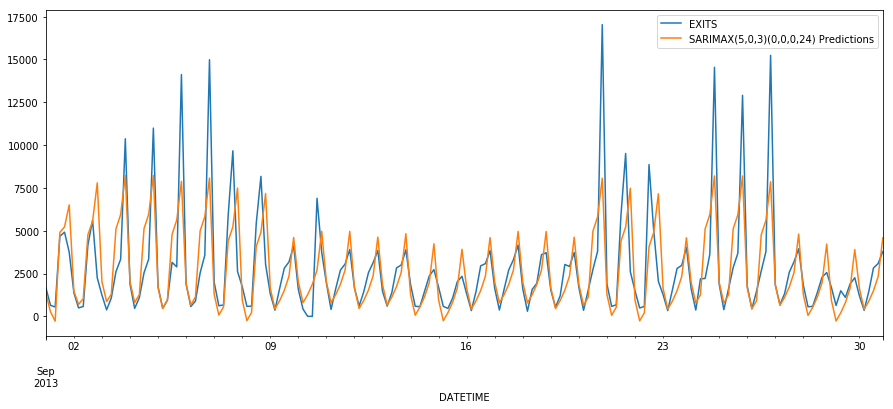

In [69]:
#train_df['EXITS'].plot(legend=True, figsize = (15,6))
test_df['EXITS'].plot(legend=True, figsize = (15,6))
predictions.plot(legend=True,figsize = (15,6))

In [70]:
rmse(predictions,test_df['EXITS'])

1933.2994141644451

# Artifical Neural Network (ANN)

In [71]:
import tensorflow as tf
print(tf.__version__)

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# More imports
#from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import RootMeanSquaredError

In [ ]:

from datetime import date, timedelta
pd.set_option('display.float_format', lambda x: '%.2f' % x)
%matplotlib inline

## One-Hot-Encode

In [ ]:
#One Hot Encode TEAM, DAYOFWEEK, HOUR

TEAM_ohe = OneHotEncoder()
DAYOFWEEK_ohe = OneHotEncoder()
HOUR_ohe = OneHotEncoder()
TEAM_ohe_array = TEAM_ohe.fit_transform(season_2013_df.TEAM.values.reshape(-1,1)).toarray()
DAYOFWEEK_ohe_array = DAYOFWEEK_ohe.fit_transform(season_2013_df.DAYOFWEEK.values.reshape(-1,1)).toarray()
HOUR_ohe_array = HOUR_ohe.fit_transform(season_2013_df.HOUR.values.reshape(-1,1)).toarray()

print(TEAM_ohe_array.shape, DAYOFWEEK_ohe_array.shape, HOUR_ohe_array.shape )


In [ ]:
TEAM_ohe_array

In [ ]:
DAYOFWEEK_ohe_array

In [ ]:
HOUR_ohe_array

In [ ]:
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
hours = [0,4,8,12,16,20]

season_2013_enc_df = season_2013_df.copy()

TEAM_df = pd.DataFrame(TEAM_ohe_array, columns = ["TEAM_" + le.classes_[i]  for i in range(len(le.classes_))], index=season_2013_df.index)
TEAM_df = TEAM_df.astype(int)
season_2013_enc_df = pd.concat([season_2013_enc_df, TEAM_df], axis=1)

DAYOFWEEK_df = pd.DataFrame(DAYOFWEEK_ohe_array, columns = ["DAYOFWEEK_" + weekday for weekday in weekdays], index=season_2013_df.index)
DAYOFWEEK_df = DAYOFWEEK_df.astype(int)
season_2013_enc_df = pd.concat([season_2013_enc_df, DAYOFWEEK_df], axis=1)

HOUR_df = pd.DataFrame(HOUR_ohe_array, columns = ["HOUR_" + str(hour) for hour in hours], index=season_2013_df.index)
HOUR_df = HOUR_df.astype(int)
season_2013_enc_df = pd.concat([season_2013_enc_df, HOUR_df], axis=1)

season_2013_enc_df = season_2013_enc_df.drop(['DAYOFWEEK','TEAM','HOUR','ENTRIES'],axis=1)
#season_2013_enc_df = season_2013_enc_df.drop(['DAYOFWEEK','HOUR','ENTRIES'],axis=1)


season_2013_enc_df.shape

In [ ]:
season_2013_enc_df.head()

In [ ]:
season_2013_enc_df.index.get_loc('2013-09-01 00:00:00')

In [ ]:
y = season_2013_enc_df['EXITS'].values.reshape(-1,1)

X = season_2013_enc_df.iloc[:,1:len(season_2013_enc_df)].values

In [ ]:
y.shape, X.shape

In [ ]:
X_train = X[:917]
X_test = X[917:]
y_train = y[:917]
y_test = y[917:]

In [ ]:
X_train.shape[1]

In [ ]:
model = Sequential()

model.add(Dense(256, input_dim = X_train.shape[1], activation='relu'))
# 16 Neurons (Play around with this number!)
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the layers
model.compile(loss='mse', metrics=[RootMeanSquaredError(name='rmse')], optimizer='adam')

In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train, epochs=300, verbose=1)

In [ ]:
pred_y = model.predict(X_test)

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(pred_y,label='ANN Predictions')
plt.plot(y_test, label='Actual')
plt.xticks(range(0, len(X_idx_val), 12), xticks.strftime("%a %m-%d"), rotation=90,ha="left")
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error
import math
math.sqrt(mean_squared_error(pred_y,y_test))

## Recursive Neural Network (RNN)

In [ ]:
# More imports
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

In [ ]:
# Start by doing the WRONG thing - trying to predict the price itself
series = season_2013_df['EXITS'].values.reshape(-1,1)


In [ ]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:917])
series = scaler.transform(series).flatten()

In [ ]:
series

In [ ]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 5
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, D) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

In [ ]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# train the RNN
r = model.fit(X, Y, epochs=80)

In [ ]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs


In [ ]:
targets = scaler.inverse_transform(series)
predictions_unscaled = scaler.inverse_transform(predictions)
targets.shape, predictions_unscaled.shape

In [ ]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape,Y.shape)
predictions = outputs[:,0]

target_unscaled = scaler.inverse_transform(Y[917:])
predictions_unscaled = scaler.inverse_transform(predictions[917-6:-6])

plt.figure(figsize=(15,6))
plt.plot(target_unscaled, label='targets')
plt.plot(predictions_unscaled, label='RNN predictions')
plt.xticks(range(0, len(X_idx_val), 12), xticks.strftime("%a %m-%d"), rotation=90,ha="left")
plt.legend()
plt.show()

In [ ]:
len(target_unscaled), len(predictions_unscaled)

In [ ]:
math.sqrt(mean_squared_error(target_unscaled,predictions_unscaled))

In [ ]:
len(Y)

In [ ]:
# Multi-step RNN forecast

N = season_2013_df.index.get_loc('2013-09-01 00:00:00')

N

In [ ]:
# Multi-step forecast
validation_target = Y[917:]
validation_predictions = []

# last train input
last_x = X[916] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [ ]:
validation_target_unscaled = scaler.inverse_transform(validation_target)
validation_predictions_unscaled =  scaler.inverse_transform(validation_predictions)

In [ ]:
plt.figure(figsize=(15,6))   
plt.plot(validation_target_unscaled, label='Targets')
plt.xticks(range(0, len(X_idx_val), 12), xticks.strftime("%a %m-%d"), rotation=90,ha="left")
plt.plot(validation_predictions_unscaled, label='RNN Predictions')
plt.legend(loc=(1.01,0))
plt.legend()

In [ ]:
rmse(validation_target_unscaled,validation_predictions_unscaled)

## Random Forest Regressor

In [ ]:
#Fit a Random Forest model with 100 tree models to the data

from sklearn.ensemble import RandomForestRegressor
from random import seed
import math

seed(1)
random_forest = RandomForestRegressor(n_estimators=100, random_state=0)

# Create the test set as the month of Sept 2013

n_train = season_2013_df.index.get_loc('2013-09-01 00:00:00')

fitted_random_forest = random_forest.fit(X_train, y_train)

In [ ]:
#Plot actual and predicted Yankee Stadium turnstile values

X = season_2013_df.index.strftime("%s").values.reshape(-1,1)
y_pred = fitted_random_forest.predict(X_test)
y_pred_train = fitted_random_forest.predict(X_train)

In [ ]:
plt.figure(figsize=(15,6))
plt.xticks(range(0, len(X), 12), xticks.strftime("%a %m-%d"), rotation=90,ha="left")
plt.plot(range(n_train), y_train, label="train")
plt.plot(range(n_train, len(y_test) + n_train), y_test, '-' ,label="test")
plt.plot(range(n_train), y_pred_train, '--', label="prediction train")

plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="prediction test")
plt.legend(loc=(1.01,0))
plt.xlabel("Date")
plt.ylabel("Exits")

In [ ]:
#Plot only the Test Region

X_idx_val = season_2013_df.index[:len(X_train) + len(X_test) -1].strftime("%s").values.reshape(-1,1)
y_pred_val = y_pred[:len(X_train) + len(X_test) -1]

plt.figure(figsize=(15,6))
plt.xticks(range(0, len(X_idx_val), 12), xticks.strftime("%a %m-%d"), rotation=90,ha="left")
plt.plot(range(n_train, len(y_test) + n_train), y_test, '-' ,label="Target")

plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="RF Predictions")
plt.legend(loc=(1.01,0))
plt.xlabel("Date")
plt.ylabel("Exits")

In [ ]:
y_pred_val

In [ ]:
print('test-set RMSE: {:,.2f}'.format(math.sqrt(mean_squared_error(y_pred,y_test))))

In [ ]:
#Examine feature importance

#features = ['DAYOFWEEK','HOUR','HOMEGAME','ENTRIES','TEAM']
#features = ['DAYOFWEEK','HOUR','HOMEGAME','TEAM']

features = season_2013_enc_df.columns[1:]

importances = fitted_random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in fitted_random_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

In [ ]:
#Plot feature importance

plot_features = []
for f in range(X_train.shape[1]):
     plot_features.append(features[indices[f]])

plt.figure(figsize =(15,6))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), plot_features,  rotation=90,ha="left")
plt.xlim([-1, X_train.shape[1]])
plt.show()